In [1]:
%%html
<!-- Global site tag (gtag.js) - Google Analytics -->
<script async src="https://www.googletagmanager.com/gtag/js?id=UA-162045285-1"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-162045285-1');
</script>


# Covid-19 Analysis

## Presentazione del Report
Analisi della situazione italiana del Covid-19 basata sui dati della Protezione Civile. I dati sono aggiornati alle 18.30 e sono recuperati dal repository https://github.com/pcm-dpc/COVID-19. Per aggiornare i dati rilanciare il presente Notebook.

> Questo Report è stato sviluppando usando Jupyter Lab un tool che permette la scrittura di codice Python tramite Browser. 
Il codice sorgente è disponibile all'indirizzo https://github.com/pasalino/Covid-19-PyAnalysis .

> **Sono gradite le Star (stelline in alto a destra della pagina).** <br/>
> Sono graditi commenti e suggerimenti che potete inviare all'indirizzo pasalino@gmail.com oppure sulla pagina https://github.com/pasalino/Covid-19-PyAnalysis/issues .<br/>
> Qui tutte le nuove funzionalità e la Roadmap del report https://pasalino.github.io/Covid-19-PyAnalysis



## Disclosure e scarico di responsabilità

Questo report non vuole sostituirsi alle fonti ufficiali, ma ne va a completamento. Non consideratelo una fonte ufficiale ma una lettura dei dati ufficiali da un punto di vista matematico.
Non mi ritengo responsabile della diffusione di questo report se non nei limiti delal condivisione di pensiero atta a comprendere meglio i dati. I dati in questo report, non sono analizzati da esperti di settore e quindi proni ad errori.
Potrebbero esserci errori e inesattezze nel codice che produce i dati. Attraverso la pagina sopra indicata è possibile indicarle.

## Indice

In [2]:
%%html
<div id="toc"></div>

In [3]:
%%javascript
$( document ).ready(function() {
    const l = $("<a href='#Indice' class='link_index'> ^ Torna su</a>");
    l.insertAfter('h2');
    l.insertAfter('h3');
    l.insertAfter('h4');
    console.log( "ready!" );
});

<IPython.core.display.Javascript object>

In [4]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [5]:
import os
import subprocess
import pandas as pd 
import datetime
import matplotlib
import math
import numpy as np
from IPython.display import display, Markdown, Latex
from matplotlib import pyplot as plt

In [6]:
PROTEZIONE_CIVILE_REPO = 'git@github.com:pcm-dpc/COVID-19.git'
CURRENT_DIR = os.path.join(os.getcwd())
DATA_DIR = os.path.join(os.getcwd(),'data')
REPO_DIR = os.path.join(os.getcwd(),DATA_DIR,'repo')

In [7]:
COLORS = ['tomato', 'seagreen', 'magenta', 'deepskyblue', 'plum', 'orange', 'royalblue',]
COL_TOTALE_CASI = '#1376f7'
COL_ATTUALMENTE_POSITIVI = '#d30202'
COL_DECEDUTI = '#8D09B3'
COL_DIFF_POSITIVI = '#d11212'
COL_GUARITI = 'deepskyblue'
COL_TOT_RICOVERATI = '#FF352D'
COL_ISOLAMENTO_DOMICILIARE = '#FDCEB5'
COL_TERAPIA_INTENSIVA = "#B34220"
COL_RICOVERATI ='#FF7554'
COL_TAMPONI= '#bce079'

COL_AVG= 'green'

NAME_LABELS= {
    'data':'DATA', 
    'ricoverati_con_sintomi':'RICOVERATI', 
    'terapia_intensiva':'TERAPIA INT.',
    'totale_ospedalizzati':'TOT. RICOV.',
    'isolamento_domiciliare':'ISOLAME. DOM.',
    'totale_attualmente_positivi':'TOT. POSITIVI',
    'nuovi_attualmente_positivi':'DIFF. POSITIVI',
    'totale_nuovi_positivi':'TOT. NUOVI POS.',
    'dimessi_guariti':'GUARITI',
    'deceduti':'DECEDUTI',
    'totale_casi':'CASI TOTALI',
    'tamponi':'TAMPONI'    
}

In [8]:
if not os.path.isdir(REPO_DIR):
    p = subprocess.Popen(['git', 'clone', '--single-branch', '-b', 'master', PROTEZIONE_CIVILE_REPO, REPO_DIR])
    p.wait()
else:
    os.chdir(REPO_DIR)
    p = subprocess.Popen(['git', 'pull'])
    p.wait()
    os.chdir(REPO_DIR)
    os.chdir(CURRENT_DIR)

## Articoli di interesse per capire i numeri

* Aricolo de Il Sole 24Ore che da un senso ai numeri indicati dalla protezione civile [QUI](https://www.ilsole24ore.com/art/gli-attualmente-contagiati-e-nuovi-positivi-rebus-ogni-sera-ADGG5tF)

## Legenda

* **CASI TOTALI**: Il numero di casi totali riscontrati rispetto al giorno giorno prima. Include guariti e morti
* **DIFF. POSITIVI**: Il numero di casi che sono la differenza dei totali riscontrati in quel giorno meno i guariti e i morti (vedi l'articolo de Il Sole 24ore per capire)
* **ATTUALMENTE POSITIVI**: Il numero dei casi che sono attualmente contagiati

## Ultimo aggiornamento dei dati dalla protezione civile
Questa data è l'ultimo aggiornamento ai dati della protezione civile a cui si riferisce questo Report

In [9]:
os.chdir(REPO_DIR)
p = subprocess.Popen(['git', 'log', '-1', '--format=%cd'], stdout=subprocess.PIPE)
p.wait()
stdout = p.communicate()[0]
out = stdout.decode("utf-8").strip()
display(Markdown(f'**' + out + '**'))
os.chdir(CURRENT_DIR)

**Sat Mar 28 18:27:59 2020 +0100**

In [10]:
plt.rcParams['figure.figsize'] = [20, 7]

In [45]:
def beautify_graph(ax):
    ax.legend(loc="upper left")
    ax.set_xlabel('Date')
    ax.grid(b=True, which='major', color='#AAAAAA', linestyle=':')
    ax.minorticks_on()
    ax.grid(b=True, which='minor', color='#AAAAAA', linestyle=':', alpha=0.5)
    ax.tick_params(which='both', width=1)
    ax.tick_params(which='major', length=14)
    ax.tick_params(which='minor', length=8, color='gray')
    
def show_table(df, tail=1):
    if 'DATA' in df.columns:
        df = df.drop('DATA',axis=1)
    if 'data' in df.columns:
        df = df.drop('data',axis=1)
    return df.rename(columns = NAME_LABELS).tail(tail)


def interpolate(serie):
    X_mean = len(serie)/2
    Y_mean = np.mean(serie)
    num = 0
    den = 0
    for i in range(1, len(serie)):
        num += (i - X_mean)*(serie[i] - Y_mean)
        den += (i - X_mean)**2
    m = num / den
    c = Y_mean - m*X_mean
    x_max= abs(c/m)
    return[1, x_max], [m+c, m*x_max+c]


## Dati Nazionali

In [46]:
national_trend_read = pd.read_csv(os.path.join(REPO_DIR,'dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'))

national_trend = pd.DataFrame()
national_trend['DATA'] = pd.to_datetime(national_trend_read['data']).dt.strftime('%d-%b-%y')
national_trend['data'] = pd.to_datetime(national_trend_read['data']).dt.strftime('%d-%b-%y')
national_columns = ['totale_casi','totale_attualmente_positivi','nuovi_attualmente_positivi', 'dimessi_guariti', 'deceduti','totale_ospedalizzati',  'ricoverati_con_sintomi', 'terapia_intensiva',  'isolamento_domiciliare', 'tamponi']
for n in national_columns:
    national_trend[n] = national_trend_read[n]

national_trend.set_index(keys=['DATA'], append=False, inplace=True)
national_trend.index.rename('', inplace=True)

### I dati di oggi

In [47]:
incremental_data = pd.DataFrame()
incremental_columns = ['data','totale_casi','nuovi_attualmente_positivi', 'dimessi_guariti', 'deceduti','totale_ospedalizzati',  'ricoverati_con_sintomi', 'terapia_intensiva',  'isolamento_domiciliare', 'totale_attualmente_positivi','tamponi']

for c in incremental_columns:
    if c in ['nuovi_attualmente_positivi','data']:
        incremental_data[c] = national_trend[c]
    else:
        incremental_data[c] = national_trend[c] - national_trend[c].shift(1)
        incremental_data[c] = incremental_data[c].astype(pd.Int64Dtype())
    
incremental_data

complete_incremental_data = incremental_data
incremental_data = incremental_data[1:]

In [48]:
show_table(incremental_data).drop('TOT. POSITIVI', axis=1)

,CASI TOTALI,DIFF. POSITIVI,GUARITI,DECEDUTI,TOT. RICOV.,RICOVERATI,TERAPIA INT.,ISOLAME. DOM.,TAMPONI
,,,,,,,,,
28-Mar-20,5974,3651,1434,889,771,647,124,2880,35447


### I dati cumulati di oggi

In [49]:
show_table(national_trend).drop('DIFF. POSITIVI', axis=1)

,CASI TOTALI,TOT. POSITIVI,GUARITI,DECEDUTI,TOT. RICOV.,RICOVERATI,TERAPIA INT.,ISOLAME. DOM.,TAMPONI
,,,,,,,,,
28-Mar-20,92472,70065,12384,10023,30532,26676,3856,39533,429526


#### Grafico della progressione giornaliera
Ogni punto indica il numero di casi evidenziati in quel giorno

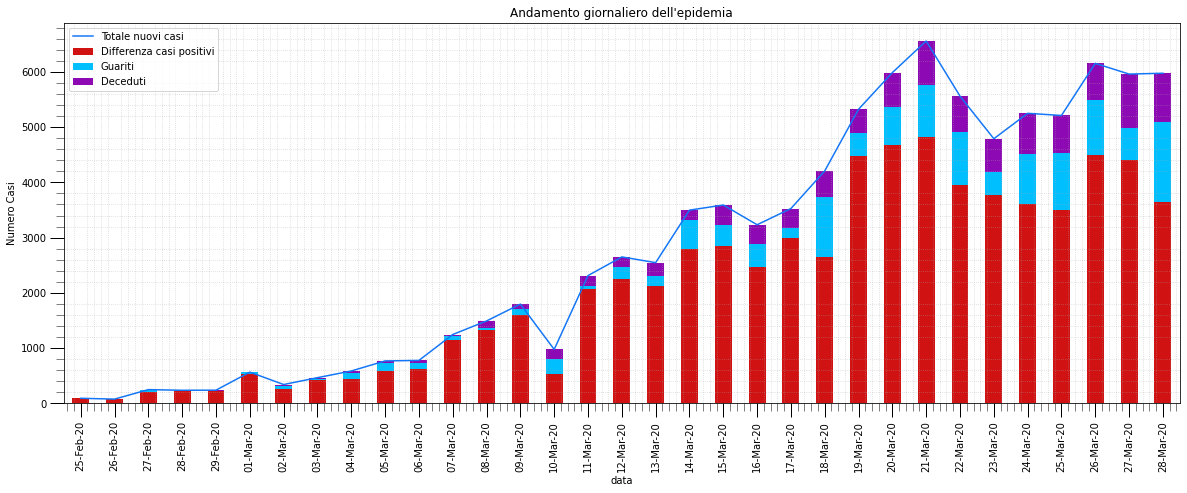

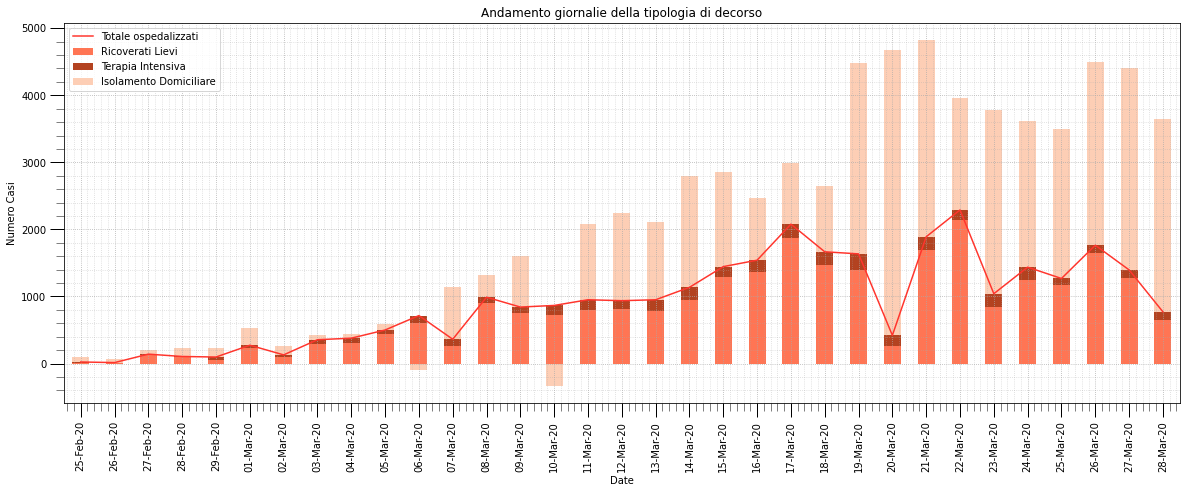

In [50]:
plot =['totale_casi']
legends = ["Totale nuovi casi"]
colors = [COL_TOTALE_CASI]
ax = incremental_data.plot(kind='line', x='data', y=plot, color=colors, rot=90, label=legends)
ax.set_ylabel('Numero Casi')
ax.set_title("Andamento giornaliero dell'epidemia")
beautify_graph(ax)

plot =['nuovi_attualmente_positivi','dimessi_guariti','deceduti']
legends = ["Differenza casi positivi","Guariti","Deceduti"]
colors = [COL_DIFF_POSITIVI, COL_GUARITI, COL_DECEDUTI]
ay = incremental_data.plot(kind='bar', x='data', y=plot, color=colors, rot=90, label=legends, stacked=True, ax=ax)

legends = ["Totale ospedalizzati"]
colors = [COL_TOT_RICOVERATI]
aw = incremental_data.plot(kind='line', x='data', y=['totale_ospedalizzati'], color=[COL_TOT_RICOVERATI], rot=90, label=legends)

plot =['ricoverati_con_sintomi', 'terapia_intensiva','isolamento_domiciliare',]
legends = ["Ricoverati Lievi","Terapia Intensiva","Isolamento Domiciliare"]
colors = [COL_RICOVERATI, COL_TERAPIA_INTENSIVA, COL_ISOLAMENTO_DOMICILIARE]
az = incremental_data.plot(kind='bar', x='data', y=plot, color=colors, rot=90, stacked=True, label=legends, ax=aw)
aw.set_title("Andamento giornalie della tipologia di decorso")
aw.set_ylabel('Numero Casi')
beautify_graph(aw)



#### I dati degli ultimi 5 giorni

In [51]:
show_table(incremental_data.rename(columns=NAME_LABELS),5).drop('TOT. POSITIVI', axis=1)

,CASI TOTALI,DIFF. POSITIVI,GUARITI,DECEDUTI,TOT. RICOV.,RICOVERATI,TERAPIA INT.,ISOLAME. DOM.,TAMPONI
,,,,,,,,,
24-Mar-20,5249,3612,894,743,1437,1245,192,2175,21496
25-Mar-20,5210,3491,1036,683,1268,1175,93,2223,27481
26-Mar-20,6153,4492,999,662,1764,1641,123,2728,36615
27-Mar-20,5959,4401,589,969,1396,1276,120,3005,33019
28-Mar-20,5974,3651,1434,889,771,647,124,2880,35447


### Andamento Nazionale
I dati cumulati nei giorni. Ci da idea di come sta evolvendo l'epidemia.

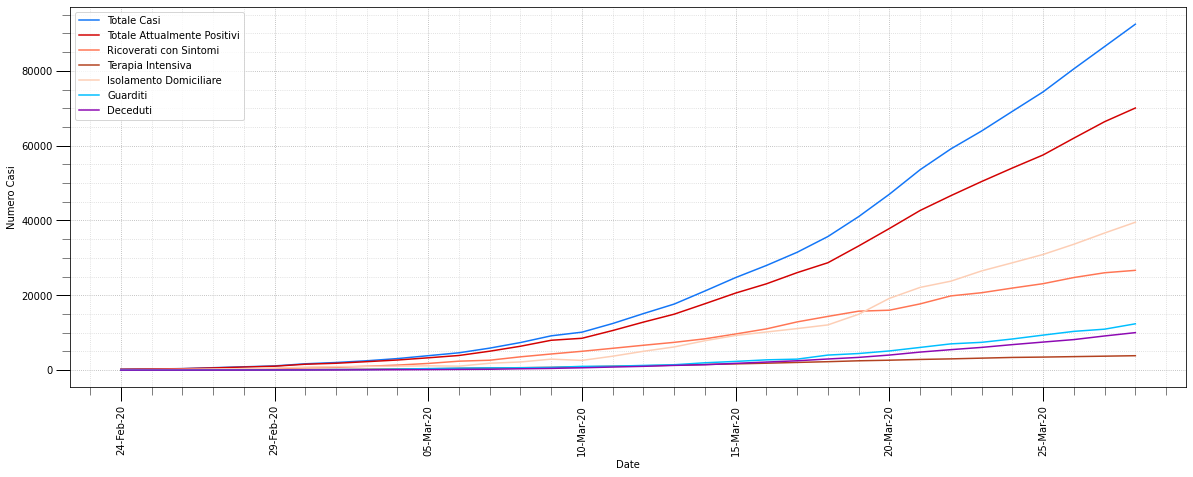

In [52]:
plot =['totale_casi','totale_attualmente_positivi','ricoverati_con_sintomi', 'terapia_intensiva','isolamento_domiciliare','dimessi_guariti','deceduti']
legends = ["Totale Casi", "Totale Attualmente Positivi","Ricoverati con Sintomi","Terapia Intensiva","Isolamento Domiciliare","Guarditi", "Deceduti"]
colors = [COL_TOTALE_CASI, COL_ATTUALMENTE_POSITIVI, COL_RICOVERATI, COL_TERAPIA_INTENSIVA, COL_ISOLAMENTO_DOMICILIARE, COL_GUARITI, COL_DECEDUTI]
ax = national_trend.plot(kind='line', x='data', y=plot, color=colors, rot=90, label=legends)
ax.set_ylabel('Numero Casi')
beautify_graph(ax)

#### I dati degli ultimi 5 giorni

In [53]:
show_table(national_trend.rename(columns = NAME_LABELS),5).drop('DIFF. POSITIVI', axis=1)

,CASI TOTALI,TOT. POSITIVI,GUARITI,DECEDUTI,TOT. RICOV.,RICOVERATI,TERAPIA INT.,ISOLAME. DOM.,TAMPONI
,,,,,,,,,
24-Mar-20,69176,54030,8326,6820,25333,21937,3396,28697,296964
25-Mar-20,74386,57521,9362,7503,26601,23112,3489,30920,324445
26-Mar-20,80539,62013,10361,8165,28365,24753,3612,33648,361060
27-Mar-20,86498,66414,10950,9134,29761,26029,3732,36653,394079
28-Mar-20,92472,70065,12384,10023,30532,26676,3856,39533,429526


### Growth rate %. Fattori di crescita
I fattori di crescita sono valori percentuali che di danno idea rispetto al giorno prima di come si muove l'epidemia e la sua velocità.

In [54]:
growth_rates = pd.DataFrame()
growth_rates['data'] = pd.to_datetime(national_trend['data']).dt.date
growth_rates_columns = ['totale_casi','nuovi_attualmente_positivi', 'totale_attualmente_positivi', 'dimessi_guariti', 'deceduti', 'totale_ospedalizzati', 'ricoverati_con_sintomi', 'terapia_intensiva', 'isolamento_domiciliare',  'tamponi']

for c in growth_rates_columns:
    growth_rates[c] = (national_trend[c] - national_trend[c].shift(1))/national_trend[c].shift(1)*100
growth_rates= growth_rates.round(2)
growth_rates=growth_rates[1:]

In [55]:
show_table(growth_rates.rename(columns=NAME_LABELS),1)

,CASI TOTALI,DIFF. POSITIVI,TOT. POSITIVI,GUARITI,DECEDUTI,TOT. RICOV.,RICOVERATI,TERAPIA INT.,ISOLAME. DOM.,TAMPONI
,,,,,,,,,,
28-Mar-20,6.91,-17.04,5.5,13.1,9.73,2.59,2.49,3.32,7.86,8.99


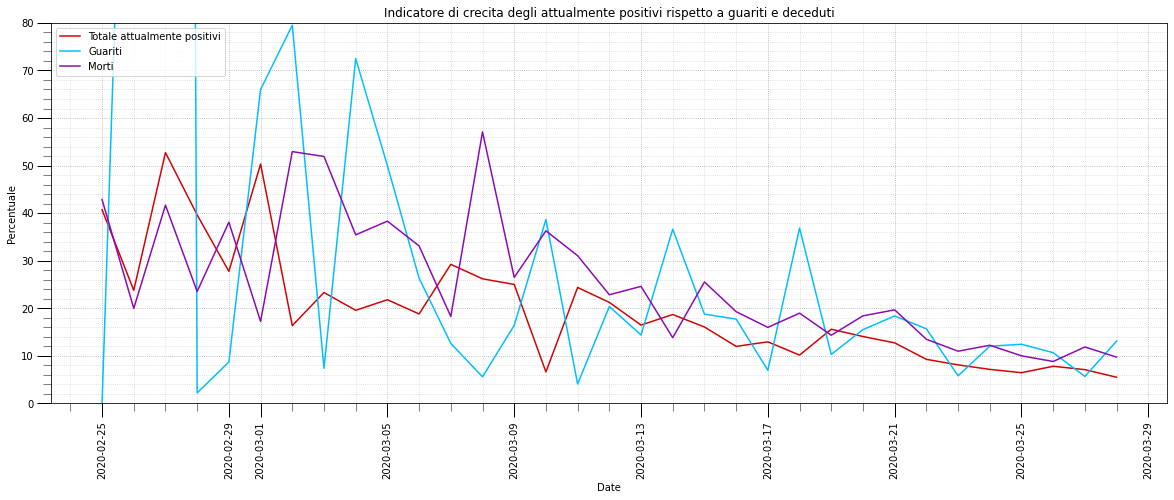

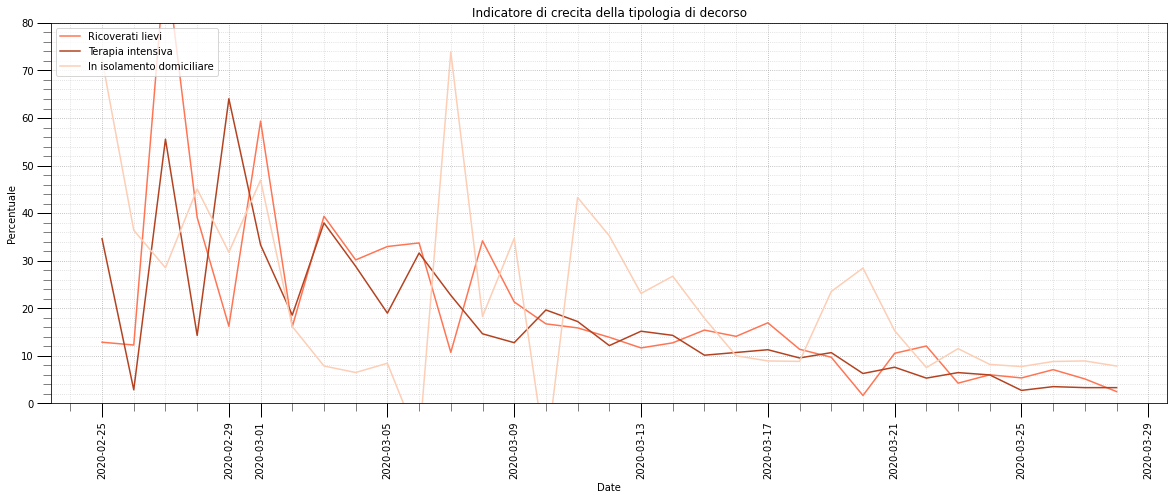

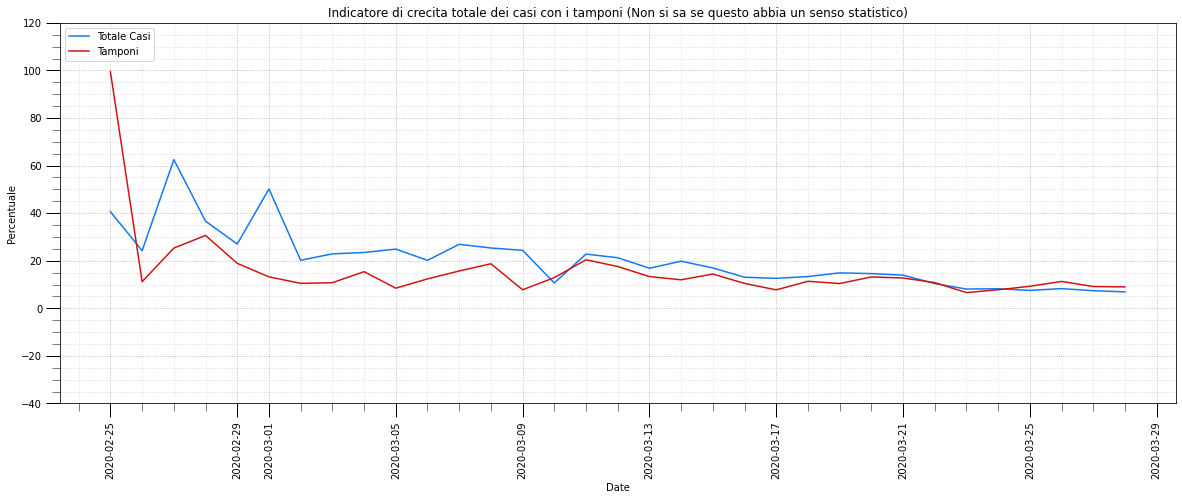

In [56]:
plot =['totale_attualmente_positivi', 'dimessi_guariti', 'deceduti', ]
labels = ['Totale attualmente positivi', 'Guariti', 'Morti', ]
colors = [COL_ATTUALMENTE_POSITIVI, COL_GUARITI, COL_DECEDUTI]
ax = growth_rates.plot(kind='line', x='data', y=plot, color=colors, label=labels, rot=90)
ax.set_ylim(0,80)
ax.set_ylabel('Percentuale')
ax.set_title("Indicatore di crecita degli attualmente positivi rispetto a guariti e deceduti")
beautify_graph(ax)

plot =['ricoverati_con_sintomi', 'terapia_intensiva', 'isolamento_domiciliare']
labels = ['Ricoverati lievi', 'Terapia intensiva', 'In isolamento domiciliare']
colors = [COL_RICOVERATI, COL_TERAPIA_INTENSIVA, COL_ISOLAMENTO_DOMICILIARE]
ay = growth_rates.plot(kind='line', x='data', y=plot, color=colors,label=labels, rot=90)
ay.set_ylim(0,80)
ay.set_ylabel('Percentuale')
ay.set_title("Indicatore di crecita della tipologia di decorso")
beautify_graph(ay)

plot =['totale_casi',  'tamponi']
labels = ['Totale Casi','Tamponi']
colors = [COL_TOTALE_CASI, COL_DIFF_POSITIVI, COL_TAMPONI]
az = growth_rates.plot(kind='line', x='data', y=plot, color=colors,label=labels, rot=90)
az.set_title("Indicatore di crecita totale dei casi con i tamponi (Non si sa se questo abbia un senso statistico)")
az.set_ylim(-40,120)
az.set_ylabel('Percentuale')
beautify_graph(az)

#### I dati degli ultimi 5 giorni
I valori sono in percentuale (%)

In [57]:
show_table(growth_rates.rename(columns=NAME_LABELS),5)

,CASI TOTALI,DIFF. POSITIVI,TOT. POSITIVI,GUARITI,DECEDUTI,TOT. RICOV.,RICOVERATI,TERAPIA INT.,ISOLAME. DOM.,TAMPONI
,,,,,,,,,,
24-Mar-20,8.21,-4.44,7.16,12.03,12.23,6.01,6.02,5.99,8.20,7.80
25-Mar-20,7.53,-3.35,6.46,12.44,10.01,5.01,5.36,2.74,7.75,9.25
26-Mar-20,8.27,28.67,7.81,10.67,8.82,6.63,7.10,3.53,8.82,11.29
27-Mar-20,7.40,-2.03,7.10,5.68,11.87,4.92,5.15,3.32,8.93,9.15
28-Mar-20,6.91,-17.04,5.50,13.10,9.73,2.59,2.49,3.32,7.86,8.99


### Trends e medie
Uno spaccato di alcuni dati.
Viene visualizzato anche il trend medio settimanale.
GR = Growth Rate - Fattore di crescita

In [58]:
avg_trend = pd.DataFrame()
avg_trend['data'] = national_trend['data']

avg_trend['totale_casi'] = national_trend['totale_casi']
avg_trend['totale_casi_percent'] = growth_rates['totale_casi']
avg_trend['avg_totale'] = growth_rates['totale_casi'].rolling(7).mean().round(2)

avg_trend['attualmente_positivi'] = national_trend['totale_attualmente_positivi']
avg_trend['attualmente_positivi_percent'] = (avg_trend['attualmente_positivi'] - avg_trend['attualmente_positivi'].shift(1))/avg_trend['attualmente_positivi'].shift(1)*100
avg_trend['attualmente_positivi_percent']= avg_trend['attualmente_positivi_percent'].round(2)
avg_trend['avg_att_positivi'] = avg_trend['attualmente_positivi_percent'].rolling(7).mean().round(2)

avg_trend['dimessi_guariti'] = national_trend['dimessi_guariti']
avg_trend['dimessi_guariti_percent'] = growth_rates['dimessi_guariti']
avg_trend['avg_dimessi_guariti'] = growth_rates['dimessi_guariti'].rolling(7).mean().round(2)

avg_trend['deceduti'] = incremental_data['deceduti']
avg_trend['deceduti_percent'] = growth_rates['deceduti']
avg_trend['avg_deceduti'] = growth_rates['deceduti'].rolling(7).mean().round(2)

avg_trend['tamponi'] = incremental_data['tamponi']
avg_trend['tamponi_percent'] = growth_rates['tamponi']
avg_trend['avg_tamponi'] = growth_rates['tamponi'].rolling(7).mean().round(2)

* **CASI TOTALI GR**: Quando questo numero sarà zero, l'epidemia si sarà fermata e tutti sono guariti.
* **NUOVI CASI TOTALI GR**: Quando questo numero sarà zero, non ci saranno più nuovi contagi e dovremo solo aspettare che tutti guardiscano
* **TAMPONI GR**: Più è alto questo numero più sono i tamponi che stanno effettuando rispetto al giorno prima. Non può andare in negativo. Se è 0 significa che non hanno fatto tamponi rispetto al giorno prima
* **DECEDUTI**: Questo numero indica di quanto aumentano rispetto al giorno prima i morti. Se questo numero va a zero significa che non ci sono più nuovi morti.

In [59]:
LABELS = {
    'nuovi_attualmente_positivi_casi': 'NUOVI CASI', 'nuovi_attualmente_positivi_percent': 'GR(%)', 'avg_nuovi': 'MEDIA 7GG (%)',
    'attualmente_positivi': 'TOT. ATTUALMENT. POS.',
    'attualmente_positivi_percent': 'GR(%)', 'avg_att_positivi': 'MEDIA 7GG (%)',
    'tamponi_percent': 'GR(%)', 'avg_tamponi': 'MEDIA 7GG (%)',
    'deceduti_percent': 'GR(%)', 'avg_deceduti':'MEDIA 7GG (%)',
    'totale_casi_percent': 'GR(%)', 'avg_totale':'MEDIA 7GG (%)',
    'dimessi_guariti_percent':'GR(%)', 'avg_dimessi_guariti':'MEDIA 7GG (%)',
}
show_table(avg_trend,5).rename(columns=LABELS)

,CASI TOTALI,GR(%),MEDIA 7GG (%),TOT. ATTUALMENT. POS.,GR(%),MEDIA 7GG (%),GUARITI,GR(%),MEDIA 7GG (%),DECEDUTI,GR(%),MEDIA 7GG (%),TAMPONI,GR(%),MEDIA 7GG (%)
,,,,,,,,,,,,,,,
24-Mar-20,69176,8.21,11.92,54030,7.16,11.01,8326,12.03,16.37,743,12.23,15.44,21496,7.80,10.41
25-Mar-20,74386,7.53,11.09,57521,6.46,10.48,9362,12.44,12.88,683,10.01,14.16,27481,9.25,10.11
26-Mar-20,80539,8.27,10.15,62013,7.81,9.37,10361,10.67,12.93,662,8.82,13.37,36615,11.29,10.24
27-Mar-20,86498,7.40,9.12,66414,7.10,8.38,10950,5.68,11.53,969,11.87,12.44,33019,9.15,9.66
28-Mar-20,92472,6.91,8.11,70065,5.50,7.34,12384,13.10,10.77,889,9.73,11.02,35447,8.99,9.13


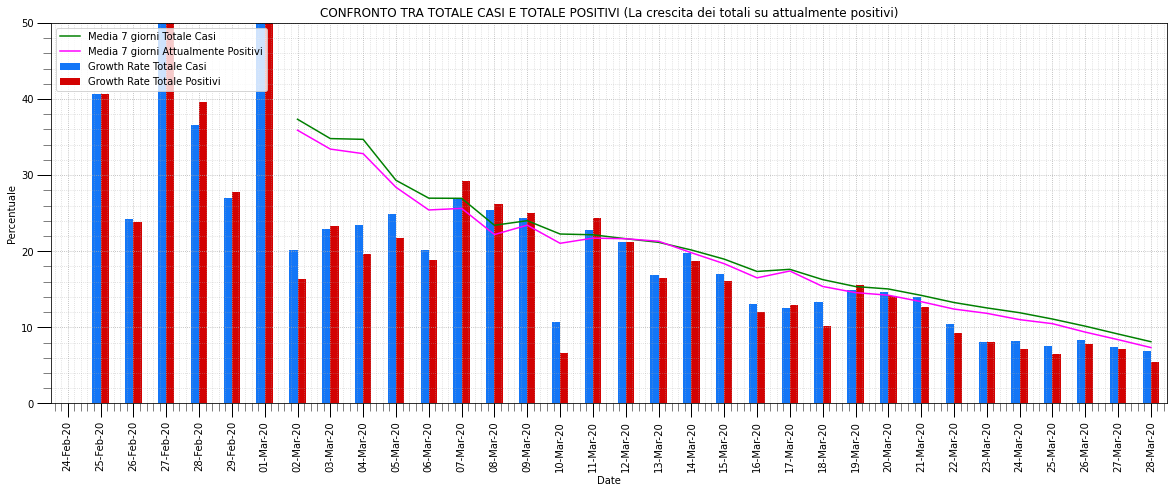

In [60]:
plot = ['totale_casi_percent','attualmente_positivi_percent']

labels = ['Growth Rate Totale Casi', 'Growth Rate Totale Positivi']
ax = avg_trend.plot(kind='bar', x='data', y=plot, color=[COL_TOTALE_CASI, COL_ATTUALMENTE_POSITIVI], rot=90, label=labels)

plot = ['avg_totale', 'avg_att_positivi']
labels = ['Media 7 giorni Totale Casi', 'Media 7 giorni Attualmente Positivi']
ay = avg_trend.plot(kind='line', x='data', y=plot, color=[COL_AVG, 'magenta'], rot=90, label=labels, ax=ax)

ax.set_ylim(0,50)
ax.set_title("CONFRONTO TRA TOTALE CASI E TOTALE POSITIVI (La crescita dei totali su attualmente positivi)")
ax.set_ylabel('Percentuale')
beautify_graph(ax)


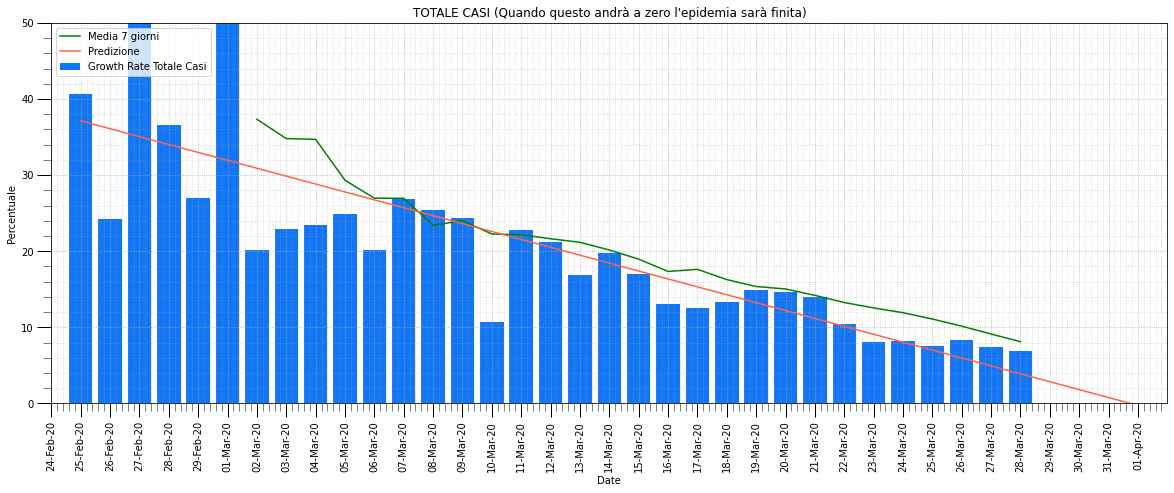

In [61]:
series = avg_trend['totale_casi_percent'].tolist()  
inter = interpolate(avg_trend['totale_casi_percent'])

x_max=math.floor(inter[0][1]) + 2
fill_elements_len =x_max - len(series)

#Crea le label delle date
start_date = datetime.datetime.strptime(avg_trend['data'].iloc[0],'%d-%b-%y')
x = [datetime.datetime.strftime(start_date + datetime.timedelta(days = x),'%d-%b-%y') for x in range(x_max)]

#Riempie le colonne vuote del grafico
fill = [0 for x in range(fill_elements_len)]
y=range(len(series+fill))

fig, ax = plt.subplots()

ax.bar(x, series+fill, color=[COL_TOTALE_CASI], label='Growth Rate Totale Casi')
ay = avg_trend.plot(kind='line', x='data', y=['avg_totale'], color=[COL_AVG], rot=90, label=['Media 7 giorni'], ax=ax)
plt.plot(inter[0], inter[1], color='tomato', label='Predizione') 

ax.set_xlim(0,x_max)
ax.set_ylim(0,50)
ax.set_title("TOTALE CASI (Quando questo andrà a zero l'epidemia sarà finita)")
ax.set_ylabel('Percentuale')
ax.set_xticklabels(x, rotation=90)
beautify_graph(ax)

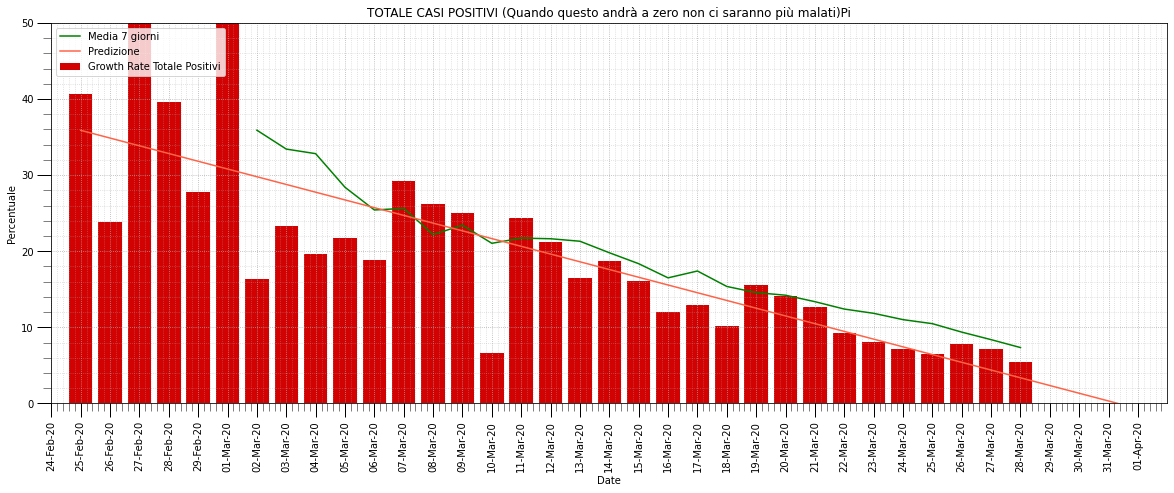

In [62]:
series = avg_trend['attualmente_positivi_percent'].tolist()  
inter = interpolate(avg_trend['attualmente_positivi_percent'])

x_max=math.floor(inter[0][1]) + 2
fill_elements_len =x_max - len(series)

#Crea le label delle date
start_date = datetime.datetime.strptime(avg_trend['data'].iloc[0],'%d-%b-%y')
x = [datetime.datetime.strftime(start_date + datetime.timedelta(days = x),'%d-%b-%y') for x in range(x_max)]

#Riempie le colonne vuote del grafico
fill = [0 for x in range(fill_elements_len)]
y=range(len(series+fill))

fig, ax = plt.subplots()

ax.bar(x, series+fill, color=[COL_ATTUALMENTE_POSITIVI], label='Growth Rate Totale Positivi')
ay = avg_trend.plot(kind='line', x='data', y=['avg_att_positivi'], color=[COL_AVG], rot=90, label=['Media 7 giorni'], ax=ax)
plt.plot(inter[0], inter[1], color='tomato', label='Predizione') 

ax.set_xlim(0,x_max)
ax.set_ylim(0,50)
ax.set_title("TOTALE CASI POSITIVI (Quando questo andrà a zero non ci saranno più malati)Pi")
ax.set_ylabel('Percentuale')
ax.set_xticklabels(x, rotation=90)
beautify_graph(ax)


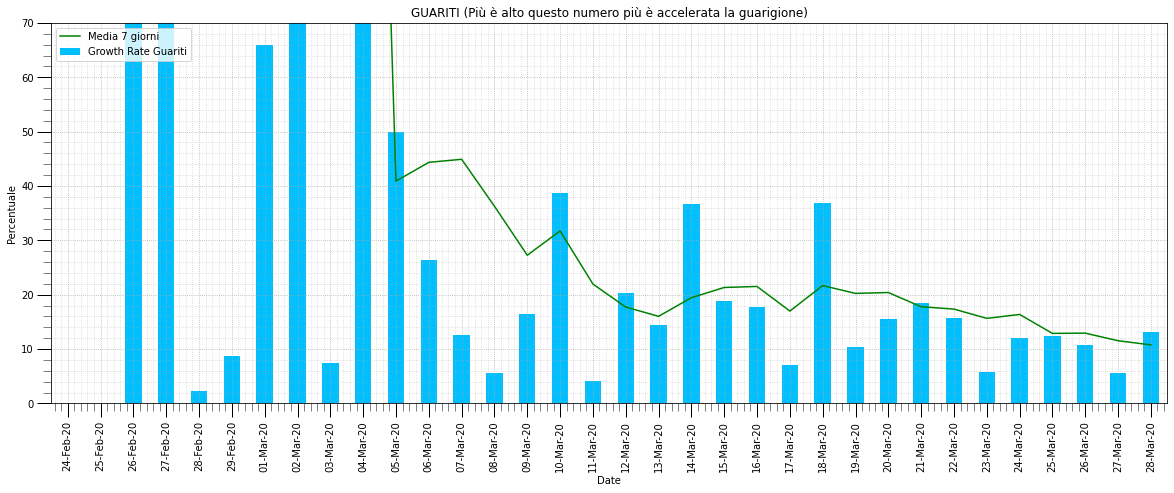

In [63]:
plot = ['dimessi_guariti_percent']

labels = ['Growth Rate Guariti']
ax = avg_trend.plot(kind='bar', x='data', y=plot, color=[COL_GUARITI], rot=90, label=labels)

plot = ['avg_dimessi_guariti']
labels = ['Media 7 giorni']
ay = avg_trend.plot(kind='line', x='data', y=plot, color=[COL_AVG], rot=90, label=labels, ax=ax)

ax.set_ylim(0,70)
ax.set_title("GUARITI (Più è alto questo numero più è accelerata la guarigione)")
ax.set_ylabel('Percentuale')
beautify_graph(ax)

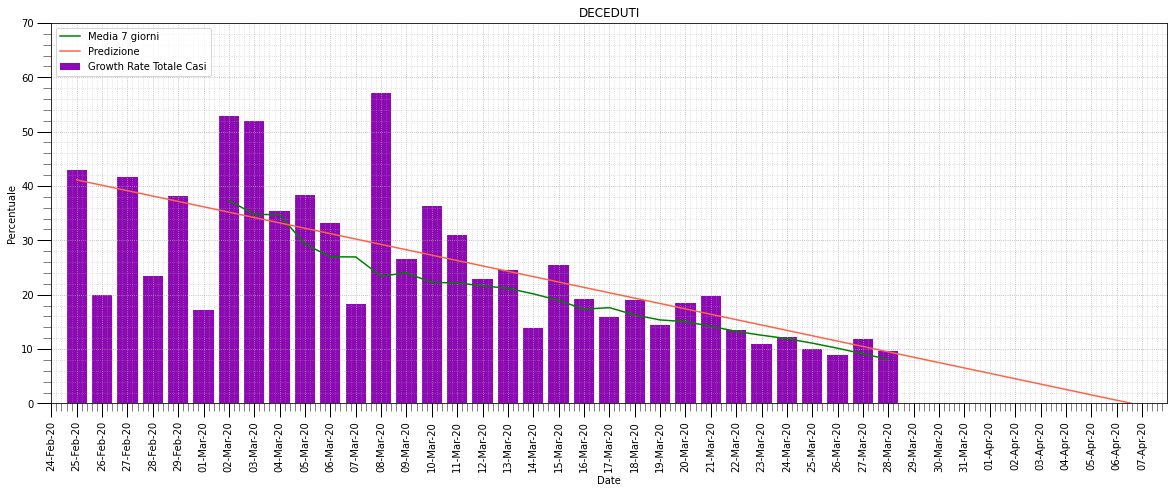

In [64]:
series = avg_trend['deceduti_percent'].tolist()  
inter = interpolate(avg_trend['deceduti_percent'])

x_max=math.floor(inter[0][1]) + 2
fill_elements_len =x_max - len(series)

#Crea le label delle date
start_date = datetime.datetime.strptime(avg_trend['data'].iloc[0],'%d-%b-%y')
x = [datetime.datetime.strftime(start_date + datetime.timedelta(days = x),'%d-%b-%y') for x in range(x_max)]

#Riempie le colonne vuote del grafico
fill = [0 for x in range(fill_elements_len)]
y=range(len(series+fill))

fig, ax = plt.subplots()

ax.bar(x, series+fill, color=[COL_DECEDUTI], label='Growth Rate Totale Casi')
ay = avg_trend.plot(kind='line', x='data', y=['avg_totale'], color=[COL_AVG], rot=90, label=['Media 7 giorni'], ax=ax)
plt.plot(inter[0], inter[1], color='tomato', label='Predizione') 

ax.set_xlim(0,x_max)
ax.set_ylim(0,70)
ax.set_title("DECEDUTI")
ax.set_ylabel('Percentuale')
ax.set_xticklabels(x, rotation=90)
beautify_graph(ax)

In [ ]:
plot = ['tamponi_percent']

labels = ['Growth Rate Nuovi Tamponi']
ax = avg_trend.plot(kind='bar', x='data', y=plot, color=[COL_TAMPONI], rot=90, label=labels)

plot = ['avg_tamponi']
labels = ['Media 7 giorni']
ay = avg_trend.plot(kind='line', x='data', y=plot, color=[COL_AVG], rot=90, label=labels, ax=ax)

ax.set_ylim(0,70)
ax.set_title("TAMPONI (Un numero più alto significa che hanno incrementato i controlli rispetto al giorno prima)")
ax.set_ylabel('Percentuale')
beautify_graph(ax)

### Divisione percentuali dei casi
Un indicazione percentuale dei dati. La fotografia ad oggi (dall'inizio dell'epidemia italiana)

In [ ]:
# Data to plot
last_info = national_trend[-1:]
v1 = int(last_info['ricoverati_con_sintomi'])
v2 = int(last_info['terapia_intensiva'])
v3 = int(last_info['isolamento_domiciliare'])
v4 = int(last_info['dimessi_guariti'])
v5 = int(last_info['deceduti'])
labels = 'Ricoverati con sintomi', 'Terapia Intensiva', 'Isolamento domiciliare', 'Guariti', 'Deceduti'
sizes = [v1, v2, v3, v4, v5]
fig1, ax1 = plt.subplots()
colors = [COL_RICOVERATI, COL_TERAPIA_INTENSIVA, COL_ISOLAMENTO_DOMICILIARE, COL_GUARITI, COL_DECEDUTI]
_, _, autotexts = ax1.pie(sizes,labels=labels,colors=colors, autopct='%1.1f%%',  startangle=90)

for autotext in autotexts:
    autotext.set_color('white')
    
ax1.axis('equal')

plt.show()


In [ ]:
percents_in_period = pd.DataFrame()
percents_in_period['data'] = national_trend['data']
percents_in_period['ricoverati_con_sintomi'] = (national_trend['ricoverati_con_sintomi'] / national_trend['totale_casi'])*100
percents_in_period['terapia_intensiva'] = (national_trend['terapia_intensiva'] / national_trend['totale_casi'])*100
percents_in_period['isolamento_domiciliare'] = (national_trend['isolamento_domiciliare'] / national_trend['totale_casi'])*100
percents_in_period['dimessi_guariti'] = (national_trend['dimessi_guariti'] / national_trend['totale_casi'])*100
percents_in_period['deceduti'] = (national_trend['deceduti'] / national_trend['totale_casi'])*100
percents_in_period['contagi'] = growth_rates['nuovi_attualmente_positivi']
percents_in_period = percents_in_period[1:].round(2)

Lo spaccato giorno per giorno percentuale. Da qui si evidenzia come si evolve l'andamento percencentuale dell'epidemia. In basso (in verde) il grafico del Growth Rate di ogni giorno rispetto al giorno precedente. Per capire come si evolvono le percentuali in base all'aumento o la diminuzione dei nuovi casi.

In [ ]:
# %matplotlib notebook
plt.rcParams['figure.figsize'] = [20, 5]

plot = ['ricoverati_con_sintomi','terapia_intensiva','isolamento_domiciliare','dimessi_guariti','deceduti']
colors = [COL_RICOVERATI, COL_TERAPIA_INTENSIVA, COL_ISOLAMENTO_DOMICILIARE, COL_GUARITI, COL_DECEDUTI]
labels = ['Ricoverati con sintomi','Terapia Intensiva','Isolamento Domiciliare','Guariti','Deceduti']
ax = percents_in_period.plot(kind='bar', x='data', y=plot, color=colors, rot=90, label=labels, stacked=True)
ax.set_ylim(0,100)

beautify_graph(ax)


## DATI REGIONALI

> IN ARRIVO